## Importamos librerías

In [109]:
# !pip install sklearn
# !Pip install graphviz

In [2]:
# Cargamos algunas librerías necesarias.
import numpy  as np  
import pandas as pd
pd.set_option('display.max_columns', 100) # Con esto garantizo el ver todas las columnas.

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt # Para dibujar alguna gráfica.
%matplotlib inline

from geopy.geocoders import Nominatim
import geocoder
import requests
import re
import threading 
import time
from math import sin, cos, sqrt, atan2, radians
import googlemaps
from geopy.geocoders import Nominatim

## Dividimos en Train y Test

In [3]:
# Dividimos el data frame en train y test para evitar tocar test.
from sklearn.model_selection import train_test_split

full_df = pd.read_csv("./Accidentefinal.csv", sep=';', decimal='.', encoding= 'utf-8')
train, test = train_test_split(full_df, test_size=0.25, shuffle=True, random_state=10)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (149993, 37)
Dimensiones del dataset de test: (49998, 37)


## Comenzamos con el análisis exploratorio y el procesamiento de datos

In [4]:
df.head()

,Unnamed: 0,Lesividad,Rango_horario,Dia_semana,Distrito,Lugar_accidente,Parte,Granizo,Hielo,Hielo.1,Lluvia,Niebla,Seco,Nieve,Mojada,Aceite,Barro,Gravilla,Hielo.2,Hielo.3,Seca_limpia,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Sexo,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Fecha_formato,Year,Mes,Dia,Dia_habil
0,3767,IL,DE 17:00 A 17:59,MARTES,CENTRO,PLAZA DE ESPAÑA,2017/3528,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,TURISMO,CONDUCTOR,MUJER,DE 55 A 59 AÑOS,40.282154,-3.791758,4.533587,muy lejos,13.337375,muy lejos,2017-11-04,2017,11,4,1
1,19465,HL,DE 17:00 A 17:59,JUEVES,PUENTE DE VALLECAS,CALLE DEL PUERTO DE BALBARAN,2017/6058,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,ATROPELLO,NO ASIGNADO,PEATON,HOMBRE,DE 0 A 5 AÑOS,40.376490,-3.655326,1.915575,muy lejos,2.628624,muy lejos,2017-06-15,2017,6,15,1
2,102659,IL,DE 13:00 A 13:59,MIERCOLES,PUENTE DE VALLECAS,CALLE DE LA SERENA - CALLE DE LOS BARROS,2012/782,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,ATROPELLO,TURISMO,CONDUCTOR,HOMBRE,DE 30 A 34 ANOS,40.377052,-3.668586,1.245211,muy lejos,2.257856,muy lejos,2012-01-25,2012,1,25,1
3,76921,IL,DE 21:00 A 21:59,VIERNES,ARGANZUELA,AUTOVIA M-30 CALZADA 1 KM.,2012/11359,NO,NO,NO,SI,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,COLISIÓN MÚLTIPLE,TURISMO,CONDUCTOR,HOMBRE,DE 45 A 49 AÑOS,40.396602,-3.703340,0.140841,Muy cerca,0.186728,Muy cerca,2012-12-14,2012,12,14,1
4,163563,HL,DE 15:00 A 15:59,JUEVES,CENTRO,PLAZA DEL EMPERADOR CARLOS V,2010/7926,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,AUTO-TAXI,CONDUCTOR,HOMBRE,DE 25 A 29 AÑOS,40.407261,-3.693570,0.236985,Cerca,1.599631,muy lejos,2010-09-09,2010,9,9,1


In [5]:
# Nos llevamos Parte, nuestra variable objetivo, a la primera columna para facilitar luego el código.
col_name="Sexo"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)
df.head(2)

,Sexo,Unnamed: 0,Lesividad,Rango_horario,Dia_semana,Distrito,Lugar_accidente,Parte,Granizo,Hielo,Hielo.1,Lluvia,Niebla,Seco,Nieve,Mojada,Aceite,Barro,Gravilla,Hielo.2,Hielo.3,Seca_limpia,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Fecha_formato,Year,Mes,Dia,Dia_habil
0,MUJER,3767,IL,DE 17:00 A 17:59,MARTES,CENTRO,PLAZA DE ESPAÑA,2017/3528,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,TURISMO,CONDUCTOR,DE 55 A 59 AÑOS,40.282154,-3.791758,4.533587,muy lejos,13.337375,muy lejos,2017-11-04,2017,11,4,1
1,HOMBRE,19465,HL,DE 17:00 A 17:59,JUEVES,PUENTE DE VALLECAS,CALLE DEL PUERTO DE BALBARAN,2017/6058,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,ATROPELLO,NO ASIGNADO,PEATON,DE 0 A 5 AÑOS,40.376490,-3.655326,1.915575,muy lejos,2.628624,muy lejos,2017-06-15,2017,6,15,1


In [6]:
# Quitamos a los testigos y reiniciamos el índice
df = df[df['Sexo'] != 'NO ASIGNADO'].reset_index(drop=True)
df = df[df['Tipo_vehiculo'] != 'NO ASIGNADO'].reset_index(drop=True)
df.shape

(138728, 37)

In [7]:
df.dtypes

Sexo                     object
Unnamed: 0                int64
Lesividad                object
Rango_horario            object
Dia_semana               object
Distrito                 object
Lugar_accidente          object
Parte                    object
Granizo                  object
Hielo                    object
Hielo.1                  object
Lluvia                   object
Niebla                   object
Seco                     object
Nieve                    object
Mojada                   object
Aceite                   object
Barro                    object
Gravilla                 object
Hielo.2                  object
Hielo.3                  object
Seca_limpia              object
Tipo_accidente           object
Tipo_vehiculo            object
Tipo_persona             object
Tramo_edad               object
Latitud                 float64
Longitud                float64
Distancia_ocio_km       float64
Lejania_ocio             object
Distancia_radares_km    float64
Lejania_

In [8]:
df.describe() # Vemos que solo 9 columnas son numéricas y de ellas algunas no nos sirven

,Unnamed: 0,Latitud,Longitud,Distancia_ocio_km,Distancia_radares_km,Year,Mes,Dia,Dia_habil
count,138728.000000,138728.000000,138728.000000,138728.000000,138728.000000,138728.000000,138728.000000,138728.000000,138728.000000
mean,99884.677981,40.421863,-3.691751,2.261196,3.414447,2014.145010,6.623832,15.787253,0.751420
std,57746.488536,0.245675,0.665470,68.038682,68.241641,2.579952,3.486142,8.746531,0.432191
min,0.000000,6.501534,-97.861099,0.000000,0.008182,2010.000000,1.000000,1.000000,0.000000
25%,49855.750000,40.396602,-3.708384,0.255087,1.058683,2012.000000,4.000000,8.000000,1.000000
50%,99853.500000,40.425205,-3.690491,0.667552,1.871910,2014.000000,7.000000,16.000000,1.000000
75%,149858.250000,40.448928,-3.666083,1.706891,2.727848,2016.000000,10.000000,23.000000,1.000000
max,199988.000000,50.075538,-1.346925,8742.642818,8759.490110,2018.000000,12.000000,31.000000,1.000000


In [9]:
df.isnull().sum() # Observamos las variables que tienen NaN y el número de ellos y vemos que el DF está completo

Sexo                    0
Unnamed: 0              0
Lesividad               0
Rango_horario           0
Dia_semana              0
Distrito                0
Lugar_accidente         0
Parte                   0
Granizo                 0
Hielo                   0
Hielo.1                 0
Lluvia                  0
Niebla                  0
Seco                    0
Nieve                   0
Mojada                  0
Aceite                  0
Barro                   0
Gravilla                0
Hielo.2                 0
Hielo.3                 0
Seca_limpia             0
Tipo_accidente          0
Tipo_vehiculo           0
Tipo_persona            0
Tramo_edad              0
Latitud                 0
Longitud                0
Distancia_ocio_km       0
Lejania_ocio            0
Distancia_radares_km    0
Lejania_radares         0
Fecha_formato           0
Year                    0
Mes                     0
Dia                     0
Dia_habil               0
dtype: int64

In [10]:
df.nunique() # Con esto podemos diferenciar las variables categóricas de las variables continuas

Sexo                         2
Unnamed: 0              138728
Lesividad                    4
Rango_horario               24
Dia_semana                   7
Distrito                    22
Lugar_accidente          14413
Parte                    73132
Granizo                      2
Hielo                        2
Hielo.1                      2
Lluvia                       2
Niebla                       2
Seco                         2
Nieve                        2
Mojada                       2
Aceite                       2
Barro                        2
Gravilla                     2
Hielo.2                      2
Hielo.3                      2
Seca_limpia                  2
Tipo_accidente              11
Tipo_vehiculo               11
Tipo_persona                 3
Tramo_edad                  18
Latitud                  16851
Longitud                 16866
Distancia_ocio_km        16975
Lejania_ocio                 4
Distancia_radares_km     16975
Lejania_radares              4
Fecha_fo

### Vamos a quitar las variables que no nos van a aportar nada

In [11]:
print(df['Hielo'].value_counts())
print('\n', df['Hielo.1'].value_counts())
print('\n', df['Hielo.2'].value_counts())
print('\n', df['Hielo.3'].value_counts())

NO    138611
SI       117
Name: Hielo, dtype: int64

 NO    138543
SI       185
Name: Hielo.1, dtype: int64

 NO    138611
SI       117
Name: Hielo.2, dtype: int64

 NO    138543
SI       185
Name: Hielo.3, dtype: int64


In [12]:
# Borramos Unnamed: 0 que era otro índice y Hielo.2 e Hielo.3 que son las mismas columnas que Hielo e Hielo.1
# Fecha formato vemos que tenemos esa misma fecha desglosada en 3 columnas. Lugar_accidente ya tenemos las coordenadas.
# Parte no nos importa en en esta variable objetivo.
df.drop(['Unnamed: 0', 'Parte', 'Fecha_formato', 'Hielo.2', 'Hielo.3', 'Lugar_accidente'], axis=1, inplace=True)

### Binarizamos las variables categóricas de SI y No a unos y ceros

In [13]:
df.nunique()

Sexo                        2
Lesividad                   4
Rango_horario              24
Dia_semana                  7
Distrito                   22
Granizo                     2
Hielo                       2
Hielo.1                     2
Lluvia                      2
Niebla                      2
Seco                        2
Nieve                       2
Mojada                      2
Aceite                      2
Barro                       2
Gravilla                    2
Seca_limpia                 2
Tipo_accidente             11
Tipo_vehiculo              11
Tipo_persona                3
Tramo_edad                 18
Latitud                 16851
Longitud                16866
Distancia_ocio_km       16975
Lejania_ocio                4
Distancia_radares_km    16975
Lejania_radares             4
Year                        9
Mes                        12
Dia                        31
Dia_habil                   2
dtype: int64

In [14]:
df['Granizo'] = df['Granizo'].map({'SI': 1, 'NO': 0})
df['Hielo'] = df['Hielo'].map({'SI': 1, 'NO': 0})
df['Hielo.1'] = df['Hielo.1'].map({'SI': 1, 'NO': 0})
df['Lluvia'] = df['Lluvia'].map({'SI': 1, 'NO': 0})
df['Niebla'] = df['Niebla'].map({'SI': 1, 'NO': 0})
df['Seco'] = df['Seco'].map({'SI': 1, 'NO': 0})
df['Nieve'] = df['Nieve'].map({'SI': 1, 'NO': 0})
df['Mojada'] = df['Mojada'].map({'SI': 1, 'NO': 0})
df['Aceite'] = df['Aceite'].map({'SI': 1, 'NO': 0})
df['Barro'] = df['Barro'].map({'SI': 1, 'NO': 0})
df['Gravilla'] = df['Gravilla'].map({'SI': 1, 'NO': 0})
df['Seca_limpia'] = df['Seca_limpia'].map({'SI': 1, 'NO': 0})

In [15]:
df.head()

,Sexo,Lesividad,Rango_horario,Dia_semana,Distrito,Granizo,Hielo,Hielo.1,Lluvia,Niebla,Seco,Nieve,Mojada,Aceite,Barro,Gravilla,Seca_limpia,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Year,Mes,Dia,Dia_habil
0,MUJER,IL,DE 17:00 A 17:59,MARTES,CENTRO,0,0,0,0,0,1,0,0,0,0,0,1,COLISIÓN DOBLE,TURISMO,CONDUCTOR,DE 55 A 59 AÑOS,40.282154,-3.791758,4.533587,muy lejos,13.337375,muy lejos,2017,11,4,1
1,HOMBRE,IL,DE 13:00 A 13:59,MIERCOLES,PUENTE DE VALLECAS,0,0,0,0,0,1,0,0,0,0,0,1,ATROPELLO,TURISMO,CONDUCTOR,DE 30 A 34 ANOS,40.377052,-3.668586,1.245211,muy lejos,2.257856,muy lejos,2012,1,25,1
2,HOMBRE,IL,DE 21:00 A 21:59,VIERNES,ARGANZUELA,0,0,0,1,0,0,0,1,0,0,0,0,COLISIÓN MÚLTIPLE,TURISMO,CONDUCTOR,DE 45 A 49 AÑOS,40.396602,-3.703340,0.140841,Muy cerca,0.186728,Muy cerca,2012,12,14,1
3,HOMBRE,HL,DE 15:00 A 15:59,JUEVES,CENTRO,0,0,0,0,0,1,0,0,0,0,0,1,COLISIÓN DOBLE,AUTO-TAXI,CONDUCTOR,DE 25 A 29 AÑOS,40.407261,-3.693570,0.236985,Cerca,1.599631,muy lejos,2010,9,9,1
4,HOMBRE,HG,DE 19:00 A 19:59,VIERNES,CHAMARTIN,0,0,0,0,0,1,0,0,0,0,0,1,COLISIÓN DOBLE,MOTOCICLETA,CONDUCTOR,DE 45 A 49 AÑOS,40.452368,-3.667447,0.842498,lejos,0.738071,lejos,2015,4,24,1


### Convertimos otras variables categóricas a numéricas 

In [16]:
df.nunique()

Sexo                        2
Lesividad                   4
Rango_horario              24
Dia_semana                  7
Distrito                   22
Granizo                     2
Hielo                       2
Hielo.1                     2
Lluvia                      2
Niebla                      2
Seco                        2
Nieve                       2
Mojada                      2
Aceite                      2
Barro                       2
Gravilla                    2
Seca_limpia                 2
Tipo_accidente             11
Tipo_vehiculo              11
Tipo_persona                3
Tramo_edad                 18
Latitud                 16851
Longitud                16866
Distancia_ocio_km       16975
Lejania_ocio                4
Distancia_radares_km    16975
Lejania_radares             4
Year                        9
Mes                        12
Dia                        31
Dia_habil                   2
dtype: int64

Empezamos con Lesividad

In [17]:
df['Lesividad'].value_counts() # Vemos Lesividad.

IL    69614
HL    64865
HG     4168
MT       81
Name: Lesividad, dtype: int64

In [18]:
df['Lesividad'] = df['Lesividad'].map({'IL': 0, 'HL': 1, 'HG': 2, 'MT': 3})

Seguimos con Dia_semana

In [19]:
df['Dia_semana'].value_counts()

VIERNES      23733
JUEVES       21311
MIERCOLES    21047
MARTES       20770
LUNES        19918
SABADO       16879
DOMINGO      15070
Name: Dia_semana, dtype: int64

In [20]:
df['Dia_semana'] = df['Dia_semana'].map({'LUNES': 0, 'MARTES': 1, 'MIERCOLES': 2, 'JUEVES': 3, 'VIERNES': 4, 'SABADO': 5, 'DOMINGO': 6})

Seguimos con Tipo_persona

In [21]:
df['Tipo_persona'].value_counts()

CONDUCTOR    104956
VIAJERO       33763
PEATON            9
Name: Tipo_persona, dtype: int64

In [22]:
df['Tipo_persona'] = df['Tipo_persona'].map({'CONDUCTOR': 0, 'VIAJERO': 1, 'PEATON': 2})

Seguimos con Sexo

In [23]:
df['Sexo'].value_counts()

HOMBRE    93893
MUJER     44835
Name: Sexo, dtype: int64

In [24]:
df['Sexo'] = df['Sexo'].map({'HOMBRE': 0, 'MUJER': 1})

Continuamos con Lejania_ocio

In [25]:
df['Lejania_ocio'].value_counts()

muy lejos    56410
Cerca        30521
Muy cerca    27229
lejos        24568
Name: Lejania_ocio, dtype: int64

In [26]:
df['Lejania_ocio'] = df['Lejania_ocio'].map({'Muy cerca': 0, 'Cerca': 1, 'lejos': 2, 'muy lejos': 3})

Seguimos con Lejania_radares

In [27]:
df['Lejania_radares'].value_counts()

muy lejos    107785
lejos         20426
Cerca          7636
Muy cerca      2881
Name: Lejania_radares, dtype: int64

In [28]:
df['Lejania_radares'] = df['Lejania_radares'].map({'Muy cerca': 0, 'Cerca': 1, 'lejos': 2, 'muy lejos': 3})

Vamos ahora con las que tienen un rango

In [29]:
df['Rango_horario'].value_counts()

DE 14:00 A 14:59    10161
DE 19:00 A 19:59     9850
DE 20:00 A 20:59     9259
DE 18:00 A 18:59     8903
DE 13:00 A 13:59     8626
DE 15:00 A 15:59     8257
DE 9:00 A 9:59       7973
DE 12:00 A 12:59     7875
DE 17:00 A 17:59     7845
DE 16:00 A 16:59     7744
DE 21:00 A 21:59     7537
DE 11:00 A 11:59     6749
DE 8:00 A 8:59       6520
DE 10:00 A 10:59     6276
DE 22:00 A 22:59     5855
DE 23:00 A 23:59     3934
DE 7:00 A 7:59       3648
DE 00:00 A 00:59     2611
DE 6:00 A 6:59       2123
DE 1:00 A 1:59       1961
DE 2:00 A 2:59       1450
DE 3:00 A 3:59       1303
DE 5:00 A 5:59       1142
DE 4:00 A 4:59       1126
Name: Rango_horario, dtype: int64

In [30]:
df=df.replace({"DE 00:00 A 00:59": 0,
            "DE 1:00 A 1:59": 1,
            "DE 2:00 A 2:59": 2,
            "DE 3:00 A 3:59": 3,
            "DE 4:00 A 4:59": 4,
            "DE 5:00 A 5:59": 5,
            "DE 6:00 A 6:59": 6,
            "DE 7:00 A 7:59": 7,
            "DE 8:00 A 8:59": 8,
            "DE 9:00 A 9:59": 9,
            "DE 10:00 A 10:59": 10,
            "DE 11:00 A 11:59": 11,
            "DE 12:00 A 12:59": 12,
            "DE 13:00 A 13:59": 13,
            "DE 14:00 A 14:59": 14,
            "DE 15:00 A 15:59": 15,
            "DE 16:00 A 16:59": 16,
            "DE 17:00 A 17:59": 17,
            "DE 18:00 A 18:59": 18,
            "DE 19:00 A 19:59": 19,
            "DE 20:00 A 20:59": 20,
            "DE 21:00 A 21:59": 21,
            "DE 22:00 A 22:59": 22,
            "DE 23:00 A 23:59": 23})

In [31]:
df['Tramo_edad'].value_counts()

DE 30 A 34 ANOS      18920
DE 25 A 29 AÑOS      18389
DE 35 A 39 AÑOS      17986
DE 40 A 44 AÑOS      15635
DE 45 A 49 AÑOS      13013
DE 21 A 24 AÑOS      11922
DE 50 A 54 AÑOS      10650
DE 55 A 59 AÑOS       7169
DE 18 A 20 AÑOS       5492
DE 60 A 64 AÑOS       4743
DE MAS DE 74 AÑOS     2694
DE 65 A 69 AÑOS       2668
DE 70 A 74 AÑOS       1875
DESCONOCIDA           1855
DE 0 A 5 AÑOS         1767
DE 10 A 14 AÑOS       1380
DE 15 A 17 AÑOS       1323
DE 6 A 9 AÑOS         1247
Name: Tramo_edad, dtype: int64

In [32]:
df=df.replace({"DE 0 A 5 AÑOS": 2.5,
            "DE 6 A 9 AÑOS": 7.5,
            "DE 10 A 14 AÑOS": 12,
            "DE 15 A 17 AÑOS": 16,
            "DE 18 A 20 AÑOS": 19,
            "DE 21 A 24 AÑOS": 22.5,
            "DE 25 A 29 AÑOS": 27,
            "DE 30 A 34 ANOS": 32,
            "DE 35 A 39 AÑOS": 37,
            "DE 40 A 44 AÑOS": 42,
            "DE 45 A 49 AÑOS": 47,
            "DE 50 A 54 AÑOS": 52,
            "DE 55 A 59 AÑOS": 57,
            "DE 60 A 64 AÑOS": 62,
            "DE 65 A 69 AÑOS": 67,
            "DE 70 A 74 AÑOS": 72,
            "DE MAS DE 74 AÑOS": 80})

In [33]:
df['Tramo_edad'] = df['Tramo_edad'].replace('DESCONOCIDA', np.nan, regex=True)

In [34]:
df['Tramo_edad'].mean()

38.32437368947857

In [35]:
df['Tramo_edad'].fillna(df['Tramo_edad'].mean(), inplace=True) # Variable continua

### Hacemos un mean encoding con el resto de variables

In [36]:
df.nunique()

Sexo                        2
Lesividad                   4
Rango_horario              24
Dia_semana                  7
Distrito                   22
Granizo                     2
Hielo                       2
Hielo.1                     2
Lluvia                      2
Niebla                      2
Seco                        2
Nieve                       2
Mojada                      2
Aceite                      2
Barro                       2
Gravilla                    2
Seca_limpia                 2
Tipo_accidente             11
Tipo_vehiculo              11
Tipo_persona                3
Tramo_edad                 18
Latitud                 16851
Longitud                16866
Distancia_ocio_km       16975
Lejania_ocio                4
Distancia_radares_km    16975
Lejania_radares             4
Year                        9
Mes                        12
Dia                        31
Dia_habil                   2
dtype: int64

In [37]:
categorical = ['Distrito', 'Tipo_accidente', 'Tipo_vehiculo']
# En train creamos un dict para usarlo después en test
mean_map = {}
for c in categorical:
    mean = df.groupby(c)['Sexo'].mean()
    df[c] = df[c].map(mean)    
    mean_map[c] = mean

In [38]:
df.dtypes

Sexo                      int64
Lesividad                 int64
Rango_horario             int64
Dia_semana                int64
Distrito                float64
Granizo                   int64
Hielo                     int64
Hielo.1                   int64
Lluvia                    int64
Niebla                    int64
Seco                      int64
Nieve                     int64
Mojada                    int64
Aceite                    int64
Barro                     int64
Gravilla                  int64
Seca_limpia               int64
Tipo_accidente          float64
Tipo_vehiculo           float64
Tipo_persona              int64
Tramo_edad              float64
Latitud                 float64
Longitud                float64
Distancia_ocio_km       float64
Lejania_ocio              int64
Distancia_radares_km    float64
Lejania_radares           int64
Year                      int64
Mes                       int64
Dia                       int64
Dia_habil                 int64
dtype: o

In [39]:
df.head() # Vemos los resultados.

,Sexo,Lesividad,Rango_horario,Dia_semana,Distrito,Granizo,Hielo,Hielo.1,Lluvia,Niebla,Seco,Nieve,Mojada,Aceite,Barro,Gravilla,Seca_limpia,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Year,Mes,Dia,Dia_habil
0,1,0,17,1,0.273069,0,0,0,0,0,1,0,0,0,0,0,1,0.329174,0.404695,0,57.0,40.282154,-3.791758,4.533587,3,13.337375,3,2017,11,4,1
1,0,0,13,2,0.340256,0,0,0,0,0,1,0,0,0,0,0,1,0.272408,0.404695,0,32.0,40.377052,-3.668586,1.245211,3,2.257856,3,2012,1,25,1
2,0,0,21,4,0.305949,0,0,0,1,0,0,0,1,0,0,0,0,0.369403,0.404695,0,47.0,40.396602,-3.703340,0.140841,0,0.186728,0,2012,12,14,1
3,0,1,15,3,0.273069,0,0,0,0,0,1,0,0,0,0,0,1,0.329174,0.185108,0,27.0,40.407261,-3.693570,0.236985,1,1.599631,3,2010,9,9,1
4,0,2,19,4,0.331118,0,0,0,0,0,1,0,0,0,0,0,1,0.329174,0.159579,0,47.0,40.452368,-3.667447,0.842498,2,0.738071,2,2015,4,24,1


### Creación de nuevas variables

In [40]:
# Vamos a crear Condiciones_adversas, que será la suma de cualquier condición, ya sea climática o del mal estado de la carretera
df['Condiciones_adversas'] = df['Granizo'] + df['Hielo'] + df['Hielo.1'] +df['Lluvia'] + df['Niebla'] + df['Nieve'] + df['Mojada'] + df['Aceite'] + df['Barro'] + df['Gravilla']
df['Condiciones_adversas'] = (df['Condiciones_adversas'] > 0)*1 # Con esto hacemos que todo lo que sea superior a 1 lo codificamos como 1.
df['Condiciones_adversas']

0         0
1         0
2         1
3         0
4         0
         ..
138723    1
138724    0
138725    0
138726    0
138727    1
Name: Condiciones_adversas, Length: 138728, dtype: int32

In [41]:
df['Condiciones_adversas'].value_counts()

0    119111
1     19617
Name: Condiciones_adversas, dtype: int64

In [42]:
# Vamos a crear Mal_tiempo, será la unión de cualquier condición climática adversa
df['Mal_tiempo'] = df['Granizo'] + df['Hielo'] + df['Hielo.1'] +df['Lluvia'] + df['Niebla'] + df['Nieve'] + df['Mojada']
df['Mal_tiempo'] = (df['Mal_tiempo'] > 0)*1
df['Mal_tiempo']

0         0
1         0
2         1
3         0
4         0
         ..
138723    1
138724    0
138725    0
138726    0
138727    1
Name: Mal_tiempo, Length: 138728, dtype: int32

In [43]:
df['Mal_tiempo'].value_counts()

0    119705
1     19023
Name: Mal_tiempo, dtype: int64

In [44]:
# Vamos a crear Mal_carretera que será la unión de las condiciones adversas en la carretera
df['Mal_carretera'] = df['Aceite'] + df['Barro'] + df['Gravilla']
df['Mal_carretera'] = (df['Mal_carretera'] > 0)*1
df['Mal_carretera']

0         0
1         0
2         0
3         0
4         0
         ..
138723    0
138724    0
138725    0
138726    0
138727    0
Name: Mal_carretera, Length: 138728, dtype: int32

In [45]:
# Vemos que está muy desbalanceado, por lo que el estado de las carreteras parece ser que está en niveles óptimos.
df['Mal_carretera'].value_counts()

0    138016
1       712
Name: Mal_carretera, dtype: int64

## Análisis exploratorio, buscamos Outliers

In [46]:
df.describe().T # Nos fijamos en la media, desviación típica y los cuartiles de cada una de las variables.
# Así vemos las ditribuciones de las variables y comprobamos si existen outliers.

,count,mean,std,min,25%,50%,75%,max
Sexo,138728.0,0.323186,0.467695,0.000000,0.000000,0.000000,1.000000,1.000000
Lesividad,138728.0,0.529410,0.559222,0.000000,0.000000,0.000000,1.000000,3.000000
Rango_horario,138728.0,14.116422,5.539737,0.000000,10.000000,14.000000,19.000000,23.000000
Dia_semana,138728.0,2.858428,1.912635,0.000000,1.000000,3.000000,4.000000,6.000000
Distrito,138728.0,0.323186,0.022945,0.273069,0.313028,0.326591,0.340225,0.365759
Granizo,138728.0,0.000144,0.012006,0.000000,0.000000,0.000000,0.000000,1.000000
Hielo,138728.0,0.000843,0.029029,0.000000,0.000000,0.000000,0.000000,1.000000
Hielo.1,138728.0,0.001334,0.036494,0.000000,0.000000,0.000000,0.000000,1.000000
Lluvia,138728.0,0.115413,0.319521,0.000000,0.000000,0.000000,0.000000,1.000000
Niebla,138728.0,0.002480,0.049735,0.000000,0.000000,0.000000,0.000000,1.000000


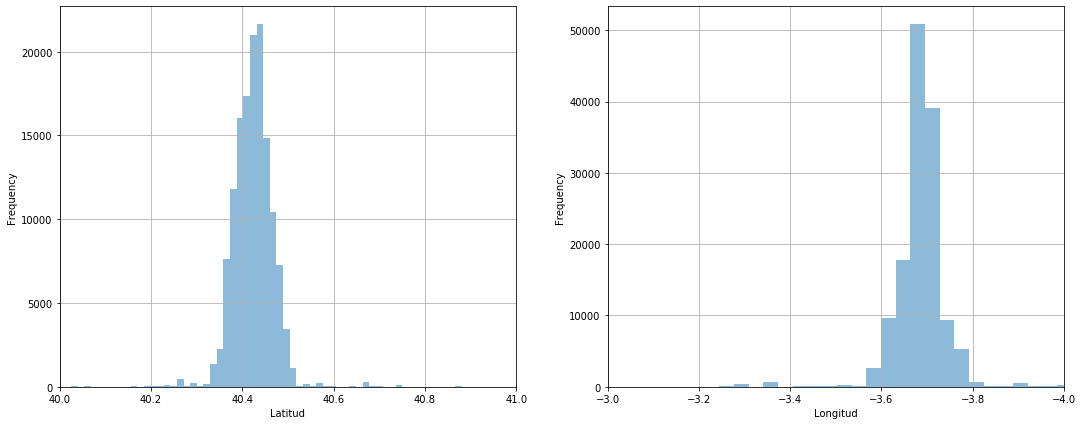

In [47]:
# Observando en la tabla de arriba cojo las variables que creo que puedan tener outliers
plt.figure(figsize=(18, 7))

plt.subplot(1,2,1)
df['Latitud'].plot.hist(alpha=0.5, bins=3000, grid = True, xlim=(40,41))
plt.xlabel('Latitud')

plt.subplot(1,2,2)
df['Longitud'].plot.hist(alpha=0.5, bins=3000, grid = True, xlim=(-3, -4))
plt.xlabel('Longitud')

plt.show()

Vemos outliers que se ven que son coordenadas fuera de Madrid

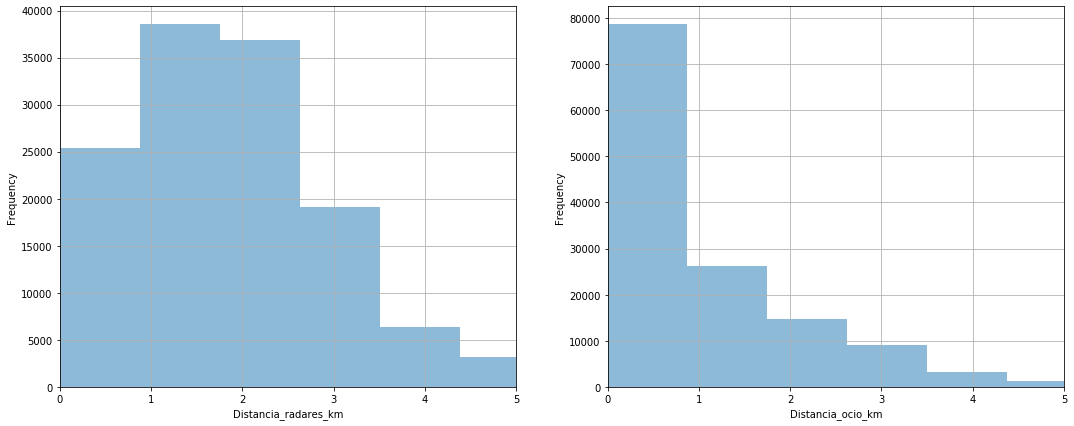

In [48]:
# Observando en la tabla de arriba cojo las variables que creo que puedan tener outliers
plt.figure(figsize=(18, 7))

plt.subplot(1,2,1)
df['Distancia_radares_km'].plot.hist(alpha=0.5, bins=10000, grid = True, xlim=(0,5))
plt.xlabel('Distancia_radares_km')

plt.subplot(1,2,2)
df['Distancia_ocio_km'].plot.hist(alpha=0.5, bins=10000, grid = True, xlim=(0,5))
plt.xlabel('Distancia_ocio_km')

plt.show()

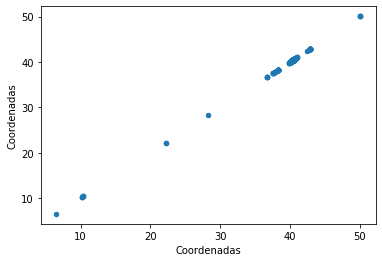

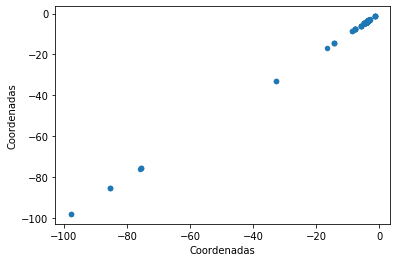

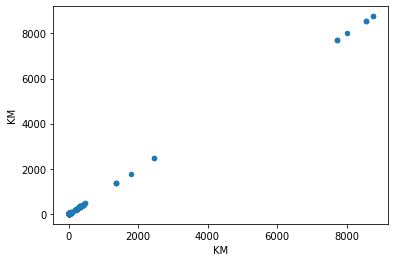

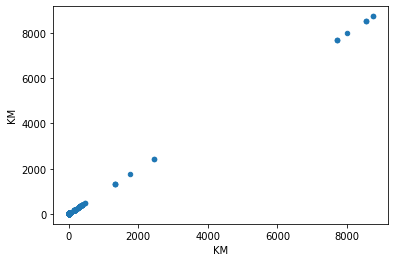

In [49]:
df.plot(kind = 'scatter',x='Latitud',y = 'Latitud')
plt.xlabel('Coordenadas')
plt.ylabel('Coordenadas')
plt.show() # Aquí podríamos filtrar por 600

df.plot(kind = 'scatter',x='Longitud',y = 'Longitud')
plt.xlabel('Coordenadas')
plt.ylabel('Coordenadas')
plt.show() # Este no me aventuraría a tocarlo porque no está tan claro que sean outliers

df.plot(kind = 'scatter',x='Distancia_radares_km',y = 'Distancia_radares_km')
plt.xlabel('KM')
plt.ylabel('KM')
plt.show() # Aquí podríamos filtrar por 200

df.plot(kind = 'scatter',x='Distancia_ocio_km',y = 'Distancia_ocio_km')
plt.xlabel('KM')
plt.ylabel('KM')
plt.show() # Aquí podríamos filtrar por 60


Ponemos unos filtros acordes a las gráficas para quitar esos outliers

In [50]:
df.shape

(138728, 34)

In [51]:
# Hemos buscado os extremos de latitud y longitud de la Comunidad de Madrid
my_filter = df['Latitud'] <= 41.16
my_filter2 = df['Latitud'] >= 39.88
my_filter3 = df['Longitud'] <= -3.05
my_filter4 = df['Longitud'] >= -4.57
df_filtered = df[my_filter & my_filter2 & my_filter3 & my_filter4]

print(df.shape)
print(df_filtered.shape) # Observamos que perdemos pocas filas, así que los aplicamos ya que solo perdemos outliers

(138728, 34)
(138650, 34)


In [52]:
df = df_filtered

In [53]:
df.corr()

,Sexo,Lesividad,Rango_horario,Dia_semana,Distrito,Granizo,Hielo,Hielo.1,Lluvia,Niebla,Seco,Nieve,Mojada,Aceite,Barro,Gravilla,Seca_limpia,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Year,Mes,Dia,Dia_habil,Condiciones_adversas,Mal_tiempo,Mal_carretera
Sexo,1.000000,0.040355,0.026142,0.012177,0.049106,-0.000595,-0.007866,-0.006669,0.004963,0.000257,-0.003996,-0.002222,0.001798,-0.010773,-0.003326,-0.011596,0.003621,0.092961,0.249611,0.328352,-0.019586,0.011471,-0.002430,0.004123,0.034844,0.000009,-0.002320,0.005478,0.001935,-0.006607,-0.018704,-0.001310,0.001796,-0.015929
Lesividad,0.040355,1.000000,-0.036527,0.004705,0.009037,-0.000631,0.012021,0.008857,0.012212,0.004900,-0.013978,-0.003517,0.020970,0.029162,0.009104,0.033659,-0.031767,-0.065961,-0.321057,0.035742,-0.098567,0.007844,-0.004207,0.001863,0.009056,0.002778,0.000219,-0.011292,0.000571,-0.000634,-0.007457,0.028995,0.021229,0.043991
Rango_horario,0.026142,-0.036527,1.000000,-0.045083,0.032547,0.004948,-0.008870,-0.009375,-0.000474,-0.032470,0.006110,-0.002402,-0.024689,0.002470,-0.006598,0.004863,0.024045,0.010676,0.039113,0.011940,-0.007969,-0.023425,0.013872,0.013786,0.048273,0.001779,-0.000485,0.016967,0.003590,-0.002379,0.055915,-0.023486,-0.024729,0.002225
Dia_semana,0.012177,0.004705,-0.045083,1.000000,-0.026258,0.003086,-0.000449,-0.001017,0.046565,-0.001391,-0.043788,-0.015345,0.043095,-0.005065,0.000390,0.001469,-0.042274,0.012431,0.059873,0.095193,-0.059880,-0.016525,-0.015714,0.001981,-0.013657,0.001418,-0.004710,-0.008899,-0.006536,-0.007805,-0.710329,0.043808,0.044707,-0.002083
Distrito,0.049106,0.009037,0.032547,-0.026258,1.000000,0.006802,0.010675,0.008327,0.011249,0.011262,-0.013666,0.008469,0.014995,-0.006009,0.010721,0.011454,-0.015185,0.053832,0.125371,0.022591,-0.014213,0.085307,0.136483,0.062603,0.517227,-0.039336,-0.034584,0.000798,0.004778,-0.005844,0.022762,0.016249,0.016242,0.006477
Granizo,-0.000595,-0.000631,0.004948,0.003086,0.006802,1.000000,0.020334,0.032465,0.014464,0.035617,-0.032692,0.015660,0.018417,0.012083,0.021501,0.012041,-0.019386,-0.009873,-0.005044,0.004379,-0.001537,-0.004586,0.001303,-0.000075,0.002121,-0.000033,0.000354,0.001885,-0.005767,0.009492,-0.005597,0.029607,0.030140,0.007546
Hielo,-0.007866,0.012021,-0.008870,-0.000449,0.010675,0.020334,1.000000,0.665776,-0.009716,0.013529,-0.076030,0.112171,0.004849,0.003851,0.008229,0.003830,-0.067021,-0.030612,-0.014282,-0.007224,-0.005135,0.007477,-0.001574,0.005066,0.014047,0.002736,-0.002062,-0.017328,0.009263,-0.021162,-0.004547,0.071634,0.072924,0.001391
Hielo.1,-0.006669,0.008857,-0.009375,-0.001017,0.008327,0.032465,0.665776,1.000000,0.015873,0.014063,-0.087281,0.221211,0.002133,0.010751,0.027724,0.002406,-0.090030,-0.028083,-0.007841,-0.007383,-0.008779,0.004438,-0.003056,0.005234,0.009493,0.003916,0.001223,-0.017756,0.009725,-0.027825,-0.003660,0.090098,0.091721,0.013973
Lluvia,0.004963,0.012212,-0.000474,0.046565,0.011249,0.014464,-0.009716,0.015873,1.000000,-0.002577,-0.980969,0.010137,0.893608,-0.009563,0.022070,-0.005849,-0.865634,-0.064341,0.005747,0.000122,-0.024895,0.007955,-0.018393,-0.003971,-0.003547,-0.000512,-0.008684,-0.006375,0.008834,-0.025273,-0.048856,0.890030,0.906059,-0.002847
Niebla,0.000257,0.004900,-0.032470,-0.001391,0.011262,0.035617,0.013529,0.014063,-0.002577,1.000000,-0.116931,0.009804,0.082645,0.000683,0.003897,0.006755,-0.088099,-0.013672,-0.003308,-0.002619,-0.002522,-0.000087,0.000655,0.001239,0.011532,-0.003229,-0.003662,0.003208,0.011369,-0.010791,-0.003515,0.122931,0.125145,0.002509


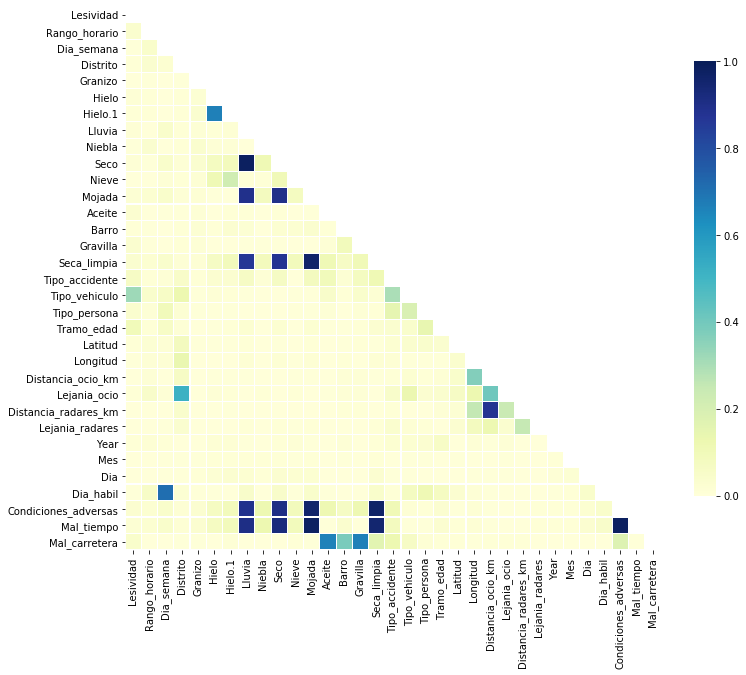

In [54]:
import seaborn as sns

# Comparamos con la variable objetivo
corr = np.abs(df.drop(['Sexo'], axis=1).corr())

# Generamos una mascara para el triángulo de arriba
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Y fijamos el tamaño del gráfico
f, ax = plt.subplots(figsize=(12, 10))

# Dibujamos el mapa de calor
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [55]:
corr = df.corr()
corr[['Sexo']].sort_values(by = 'Sexo',ascending = False)\
.style.background_gradient()

,Sexo
Sexo,1.000000
Tipo_persona,0.328352
Tipo_vehiculo,0.249611
Tipo_accidente,0.092961
Distrito,0.049106
Lesividad,0.040355
Lejania_ocio,0.034844
Rango_horario,0.026142
Dia_semana,0.012177
Latitud,0.011471


Vemos correlaciones evidentes como Lluvia con Mal_tiempo, Seco (están inversamente correladas) o Mojada y algunas no tan evidentes como Distancia_ocio_km y Distancia_radares_km por lo que deducimos que los radares los ponen cerca de zonas de ocio.

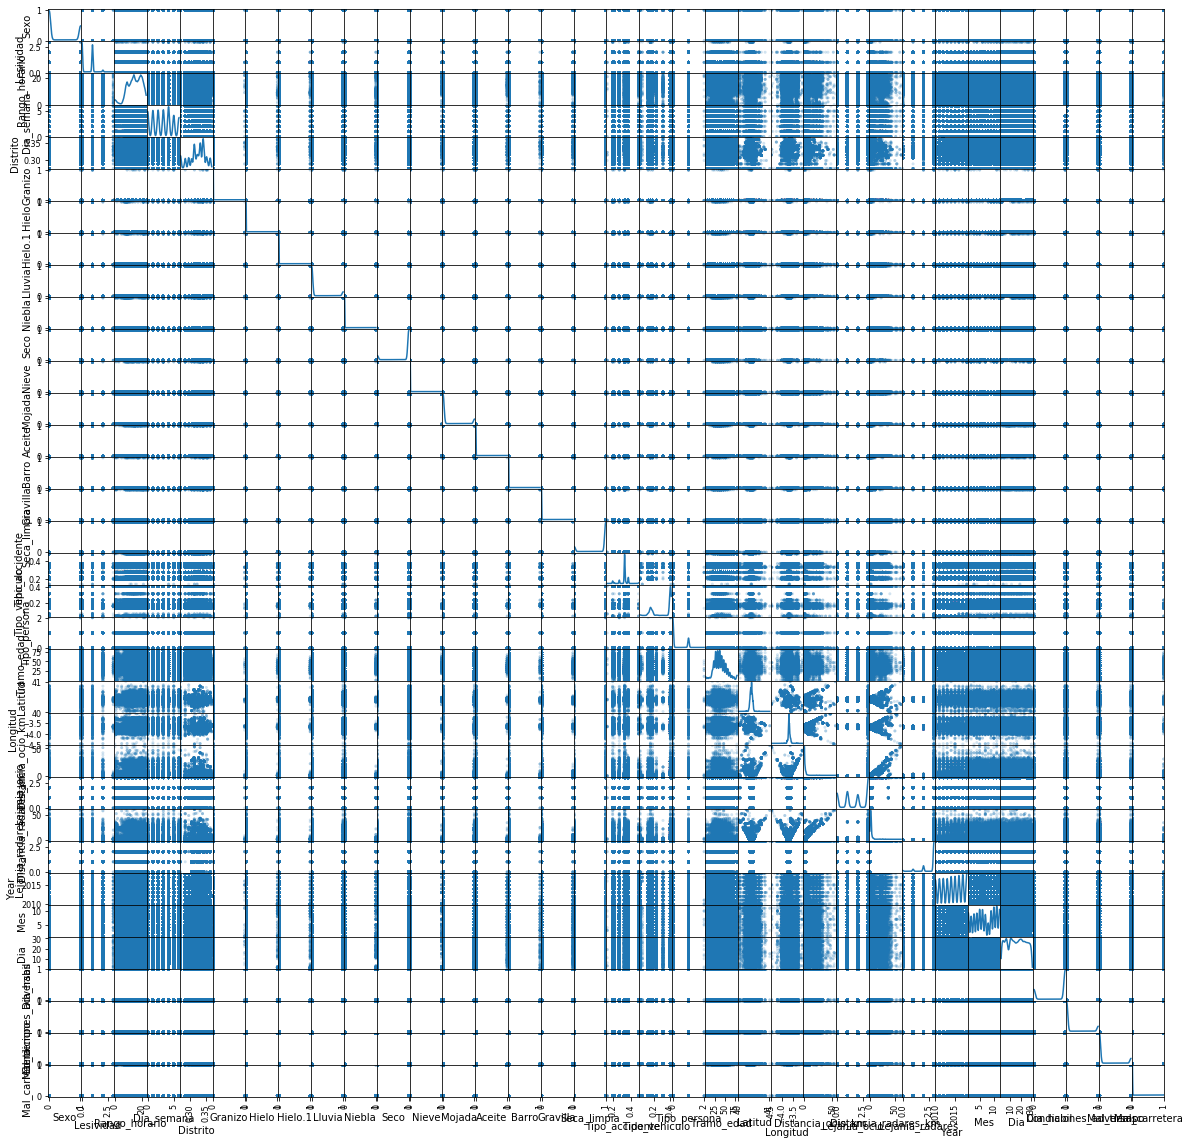

In [233]:
# pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
# plt.show() # Hacemos una representación (scatter_plot) de todas las variables frente al resto,
# # para tener una idea de cómo se relacionan las variables entre sí.

### Borramos variables que estén altamente correladas ya que no nos van a aportar mucha información

In [56]:
df.columns

Index(['Sexo', 'Lesividad', 'Rango_horario', 'Dia_semana', 'Distrito',
       'Granizo', 'Hielo', 'Hielo.1', 'Lluvia', 'Niebla', 'Seco', 'Nieve',
       'Mojada', 'Aceite', 'Barro', 'Gravilla', 'Seca_limpia',
       'Tipo_accidente', 'Tipo_vehiculo', 'Tipo_persona', 'Tramo_edad',
       'Latitud', 'Longitud', 'Distancia_ocio_km', 'Lejania_ocio',
       'Distancia_radares_km', 'Lejania_radares', 'Year', 'Mes', 'Dia',
       'Dia_habil', 'Condiciones_adversas', 'Mal_tiempo', 'Mal_carretera'],
      dtype='object')

In [57]:
df.drop(['Granizo', 'Hielo', 'Hielo.1', 'Lluvia', 'Niebla', 'Nieve', 'Seco',
             'Mojada', 'Aceite', 'Barro', 'Gravilla', 'Seca_limpia',], axis=1, inplace=True)

In [58]:
df.corr()

,Sexo,Lesividad,Rango_horario,Dia_semana,Distrito,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Year,Mes,Dia,Dia_habil,Condiciones_adversas,Mal_tiempo,Mal_carretera
Sexo,1.000000,0.040355,0.026142,0.012177,0.049106,0.092961,0.249611,0.328352,-0.019586,0.011471,-0.002430,0.004123,0.034844,0.000009,-0.002320,0.005478,0.001935,-0.006607,-0.018704,-0.001310,0.001796,-0.015929
Lesividad,0.040355,1.000000,-0.036527,0.004705,0.009037,-0.065961,-0.321057,0.035742,-0.098567,0.007844,-0.004207,0.001863,0.009056,0.002778,0.000219,-0.011292,0.000571,-0.000634,-0.007457,0.028995,0.021229,0.043991
Rango_horario,0.026142,-0.036527,1.000000,-0.045083,0.032547,0.010676,0.039113,0.011940,-0.007969,-0.023425,0.013872,0.013786,0.048273,0.001779,-0.000485,0.016967,0.003590,-0.002379,0.055915,-0.023486,-0.024729,0.002225
Dia_semana,0.012177,0.004705,-0.045083,1.000000,-0.026258,0.012431,0.059873,0.095193,-0.059880,-0.016525,-0.015714,0.001981,-0.013657,0.001418,-0.004710,-0.008899,-0.006536,-0.007805,-0.710329,0.043808,0.044707,-0.002083
Distrito,0.049106,0.009037,0.032547,-0.026258,1.000000,0.053832,0.125371,0.022591,-0.014213,0.085307,0.136483,0.062603,0.517227,-0.039336,-0.034584,0.000798,0.004778,-0.005844,0.022762,0.016249,0.016242,0.006477
Tipo_accidente,0.092961,-0.065961,0.010676,0.012431,0.053832,1.000000,0.297140,0.151606,0.033080,-0.024612,-0.016823,0.010952,0.049252,-0.010579,-0.035338,-0.026533,-0.003346,0.006691,-0.008267,-0.107523,-0.085420,-0.121424
Tipo_vehiculo,0.249611,-0.321057,0.039113,0.059873,0.125371,0.297140,1.000000,0.192768,0.039313,-0.038295,-0.006497,0.027213,0.132243,-0.002272,-0.019385,-0.024955,-0.006476,-0.007579,-0.075516,-0.017283,-0.004979,-0.063460
Tipo_persona,0.328352,0.035742,0.011940,0.095193,0.022591,0.151606,0.192768,1.000000,-0.142482,-0.039983,-0.005540,0.009126,0.027878,-0.003198,-0.008418,-0.028582,-0.003989,-0.003137,-0.117085,-0.008676,-0.005253,-0.018136
Tramo_edad,-0.019586,-0.098567,-0.007969,-0.059880,-0.014213,0.033080,0.039313,-0.142482,1.000000,0.031532,-0.005951,-0.017260,-0.035921,-0.011918,0.000028,0.060042,0.003404,0.003743,0.071368,-0.029205,-0.027631,-0.011453
Latitud,0.011471,0.007844,-0.023425,-0.016525,0.085307,-0.024612,-0.038295,-0.039983,0.031532,1.000000,0.037097,0.044529,-0.065305,0.022416,0.027853,-0.003884,-0.004256,0.000500,0.029886,0.007608,0.008532,-0.008136


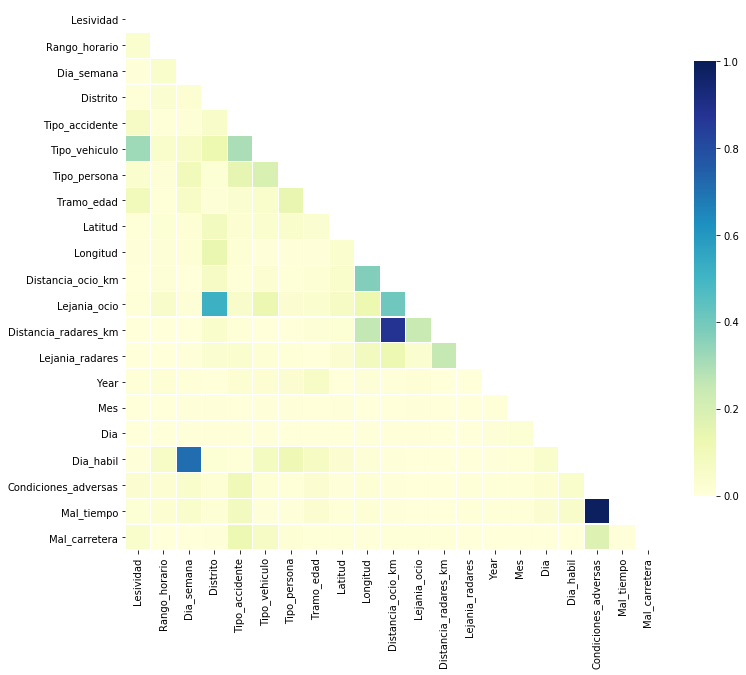

In [59]:
import seaborn as sns

# Comparamos con la variable objetivo
corr = np.abs(df.drop(['Sexo'], axis=1).corr())

# Generamos una mascara para el triángulo de arriba
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Y fijamos el tamaño del gráfico
f, ax = plt.subplots(figsize=(12, 10))

# Dibujamos el mapa de calor
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [60]:
corr = df.corr()
corr[['Sexo']].sort_values(by = 'Sexo',ascending = False)\
.style.background_gradient()

,Sexo
Sexo,1.000000
Tipo_persona,0.328352
Tipo_vehiculo,0.249611
Tipo_accidente,0.092961
Distrito,0.049106
Lesividad,0.040355
Lejania_ocio,0.034844
Rango_horario,0.026142
Dia_semana,0.012177
Latitud,0.011471


## Cargamos los datos de Test

In [61]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

In [62]:
df_test

,Unnamed: 0,Lesividad,Rango_horario,Dia_semana,Distrito,Lugar_accidente,Parte,Granizo,Hielo,Hielo.1,Lluvia,Niebla,Seco,Nieve,Mojada,Aceite,Barro,Gravilla,Hielo.2,Hielo.3,Seca_limpia,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Sexo,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Fecha_formato,Year,Mes,Dia,Dia_habil
0,19956,IL,DE 13:00 A 13:59,VIERNES,PUENTE DE VALLECAS,AVENIDA DE LA DEMOCRACIA,2016/8581,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,FURGONETA,CONDUCTOR,HOMBRE,DE 25 A 29 AÑOS,40.384336,-3.625327,0.603953,lejos,4.048786,muy lejos,2016-09-09,2016,9,9,1
1,44775,HL,DE 22:00 A 22:59,LUNES,CARABANCHEL,AVENIDA DE LOS POBLADOS - CALLE VIA LUSITANA,2010/7032,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,TURISMO,CONDUCTOR,HOMBRE,DE 25 A 29 AÑOS,40.373710,-3.732700,1.654674,muy lejos,2.671911,muy lejos,2010-02-08,2010,2,8,1
2,107246,IL,DE 13:00 A 13:59,JUEVES,CHAMBERI,CALLE DE CEA BERMUDEZ,2012/144,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,TURISMO,CONDUCTOR,MUJER,DE 65 A 69 AÑOS,40.438862,-3.706168,0.291471,Cerca,2.539667,muy lejos,2012-05-01,2012,5,1,1
3,38643,HG,DE 19:00 A 19:59,SABADO,CHAMBERI,CALLE DE FERNANDO EL SANTO - CALLE DEL MONTE E...,2017/7122,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,MOTOCICLETA,CONDUCTOR,HOMBRE,DE 30 A 34 ANOS,40.428114,-3.692087,0.083017,Muy cerca,2.713188,muy lejos,2017-07-22,2017,7,22,0
4,21093,IL,DE 16:00 A 16:59,MARTES,ARGANZUELA,CALLE DE MENDEZ ALVARO - CALLE DE ARIEL,2012/1209,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,TURISMO,VIAJERO,MUJER,DE 60 A 64 AÑOS,40.395729,-3.677837,0.991305,lejos,0.684053,lejos,2012-07-02,2012,7,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,104221,IL,DE 22:00 A 22:59,DOMINGO,CHAMBERI,CALLE DE RAIMUNDO FERNANDEZ VILLAVERDE - PASEO...,2016/10725,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,TURISMO,CONDUCTOR,HOMBRE,DE 35 A 39 AÑOS,40.446347,-3.691349,0.226177,Cerca,2.366067,muy lejos,2016-11-13,2016,11,13,0
49994,151336,HL,DE 22:00 A 22:59,DOMINGO,CENTRO,CALLE DE FUENCARRAL - CALLE DE MANUELA MALASAÑA,2015/6266,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,ATROPELLO,NO ASIGNADO,PEATON,MUJER,DE 25 A 29 AÑOS,40.428628,-3.702247,0.023082,Muy cerca,2.243194,muy lejos,2015-05-07,2015,5,7,0
49995,146987,HL,DE 10:00 A 10:59,JUEVES,MORATALAZ,CALLE DE LA ENCOMIENDA DE PALACIOS,2010/5758,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,ATROPELLO,NO ASIGNADO,PEATON,HOMBRE,DE 6 A 9 AÑOS,40.400788,-3.646709,0.734177,lejos,2.007919,muy lejos,2010-06-24,2010,6,24,1
49996,196255,IL,DE 21:00 A 21:59,DOMINGO,SAN BLAS,CALLE DE AQUITANIA - PLAZA DE ALSACIA,2015/1220,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,SI,COLISIÓN DOBLE,FURGONETA,CONDUCTOR,HOMBRE,DE 30 A 34 ANOS,40.417179,-3.622758,2.803368,muy lejos,3.091796,muy lejos,2015-08-02,2015,8,2,0


In [63]:
columnaGenero = df_test['Sexo']
df_test.drop(labels=['Sexo'], axis=1,inplace = True)
df_test.insert(0, 'Sexo', columnaGenero)

In [64]:
# Quitamos a los NO ASIGNADOS y reiniciamos el índice
df_test = df_test[df_test['Sexo'] != 'NO ASIGNADO'].reset_index(drop=True)
df_test = df_test[df_test['Tipo_vehiculo'] != 'NO ASIGNADO'].reset_index(drop=True)
df_test.shape

(46243, 37)

In [65]:
# Borramos Unnamed: 0 que era otro índice y Hielo.2 e Hielo.3 que son las mismas columnas que Hielo e Hielo.1
# Fecha formato vemos que tenemos esa misma fecha desglosada en 3 columnas. Lugar_accidente ya tenemos las coordenadas.
# Parte no nos importa en en esta variable objetivo.
df_test.drop(['Unnamed: 0', 'Parte', 'Fecha_formato', 'Hielo.2', 'Hielo.3', 'Lugar_accidente'], axis=1, inplace=True)

Pasamos las variables categóricas a numéricas.

In [66]:
df_test['Granizo'] = df_test['Granizo'].map({'SI': 1, 'NO': 0})
df_test['Hielo'] = df_test['Hielo'].map({'SI': 1, 'NO': 0})
df_test['Hielo.1'] = df_test['Hielo.1'].map({'SI': 1, 'NO': 0})
df_test['Lluvia'] = df_test['Lluvia'].map({'SI': 1, 'NO': 0})
df_test['Niebla'] = df_test['Niebla'].map({'SI': 1, 'NO': 0})
df_test['Seco'] = df_test['Seco'].map({'SI': 1, 'NO': 0})
df_test['Nieve'] = df_test['Nieve'].map({'SI': 1, 'NO': 0})
df_test['Mojada'] = df_test['Mojada'].map({'SI': 1, 'NO': 0})
df_test['Aceite'] = df_test['Aceite'].map({'SI': 1, 'NO': 0})
df_test['Barro'] = df_test['Barro'].map({'SI': 1, 'NO': 0})
df_test['Gravilla'] = df_test['Gravilla'].map({'SI': 1, 'NO': 0})
df_test['Seca_limpia'] = df_test['Seca_limpia'].map({'SI': 1, 'NO': 0})

In [67]:
df_test['Lesividad'] = df_test['Lesividad'].map({'IL': 0, 'HL': 1, 'HG': 2, 'MT': 3})
df_test['Dia_semana'] = df_test['Dia_semana'].map({'LUNES': 0, 'MARTES': 1, 'MIERCOLES': 2, 'JUEVES': 3, 'VIERNES': 4, 'SABADO': 5, 'DOMINGO': 6})
df_test['Tipo_persona'] = df_test['Tipo_persona'].map({'CONDUCTOR': 0, 'VIAJERO': 1, 'PEATON': 2})
df_test['Sexo'] = df_test['Sexo'].map({'HOMBRE': 0, 'MUJER': 1})
df_test['Lejania_ocio'] = df_test['Lejania_ocio'].map({'Muy cerca': 0, 'Cerca': 1, 'lejos': 2, 'muy lejos': 3})
df_test['Lejania_radares'] = df_test['Lejania_radares'].map({'Muy cerca': 0, 'Cerca': 1, 'lejos': 2, 'muy lejos': 3})

In [68]:
df_test=df_test.replace({"DE 00:00 A 00:59": 0,
            "DE 1:00 A 1:59": 1,
            "DE 2:00 A 2:59": 2,
            "DE 3:00 A 3:59": 3,
            "DE 4:00 A 4:59": 4,
            "DE 5:00 A 5:59": 5,
            "DE 6:00 A 6:59": 6,
            "DE 7:00 A 7:59": 7,
            "DE 8:00 A 8:59": 8,
            "DE 9:00 A 9:59": 9,
            "DE 10:00 A 10:59": 10,
            "DE 11:00 A 11:59": 11,
            "DE 12:00 A 12:59": 12,
            "DE 13:00 A 13:59": 13,
            "DE 14:00 A 14:59": 14,
            "DE 15:00 A 15:59": 15,
            "DE 16:00 A 16:59": 16,
            "DE 17:00 A 17:59": 17,
            "DE 18:00 A 18:59": 18,
            "DE 19:00 A 19:59": 19,
            "DE 20:00 A 20:59": 20,
            "DE 21:00 A 21:59": 21,
            "DE 22:00 A 22:59": 22,
            "DE 23:00 A 23:59": 23})

In [69]:
df_test=df_test.replace({"DE 0 A 5 AÑOS": 2.5,
            "DE 6 A 9 AÑOS": 7.5,
            "DE 10 A 14 AÑOS": 12,
            "DE 15 A 17 AÑOS": 16,
            "DE 18 A 20 AÑOS": 19,
            "DE 21 A 24 AÑOS": 22.5,
            "DE 25 A 29 AÑOS": 27,
            "DE 30 A 34 ANOS": 32,
            "DE 35 A 39 AÑOS": 37,
            "DE 40 A 44 AÑOS": 42,
            "DE 45 A 49 AÑOS": 47,
            "DE 50 A 54 AÑOS": 52,
            "DE 55 A 59 AÑOS": 57,
            "DE 60 A 64 AÑOS": 62,
            "DE 65 A 69 AÑOS": 67,
            "DE 70 A 74 AÑOS": 72,
            "DE MAS DE 74 AÑOS": 80})

In [70]:
df_test['Tramo_edad'] = df_test['Tramo_edad'].replace('DESCONOCIDA', np.nan, regex=True)
df_test['Tramo_edad'].fillna(df_test['Tramo_edad'].mean(), inplace=True) # Y al ser Variable continua le introducimos la media.

In [71]:
# Codificamos el resto de variables.
for c in categorical:
    df_test[c] = df_test[c].map(mean_map[c])

Creamos las mismas variables que creamos en Train

In [72]:
# Vamos a crear Condiciones_adversas, que será la suma de cualquier condición, ya sea climática o del mal estado de la carretera
df_test['Condiciones_adversas'] = df_test['Granizo'] + df_test['Hielo'] + df_test['Hielo.1'] +df_test['Lluvia'] + df_test['Niebla'] + df_test['Nieve'] + df_test['Mojada'] + df_test['Aceite'] + df_test['Barro'] + df_test['Gravilla']
df_test['Condiciones_adversas'] = (df_test['Condiciones_adversas'] > 0)*1 # Con esto hacemos que todo lo que sea superior a 1 lo codificamos como 1.

# Vamos a crear Mal_tiempo, será la unión de cualquier condición climática adversa
df_test['Mal_tiempo'] = df_test['Granizo'] + df_test['Hielo'] + df_test['Hielo.1'] +df_test['Lluvia'] + df_test['Niebla'] + df_test['Nieve'] + df_test['Mojada']
df_test['Mal_tiempo'] = (df_test['Mal_tiempo'] > 0)*1

# Vamos a crear Mal_carretera que será la unión de las condiciones adversas en la carretera
df_test['Mal_carretera'] = df_test['Aceite'] + df_test['Barro'] + df_test['Gravilla']
df_test['Mal_carretera'] = (df_test['Mal_carretera'] > 0)*1


Quitamos los outliers con los filtros de Train

In [73]:
# # Usamos los mismos filtros que usamos en Train
# my_filter = df['Latitud'] <= 41.16
# my_filter2 = df['Latitud'] >= 39.88
# my_filter3 = df['Longitud'] <= -3.05
# my_filter4 = df['Longitud'] >= -4.57
df_filtered_test = df_test[my_filter & my_filter2 & my_filter3 & my_filter4]

print(df_test.shape)
print(df_filtered_test.shape)

df_test = df_filtered_test

(46243, 34)
(46216, 34)


C:\Users\migue\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Por último quitamos las columnas que quitamos en Train tras ver su correlación

In [74]:
df_test.drop(['Granizo', 'Hielo', 'Hielo.1', 'Lluvia', 'Niebla', 'Nieve', 'Seco',
             'Mojada', 'Aceite', 'Barro', 'Gravilla', 'Seca_limpia',], axis=1, inplace=True)

In [75]:
df_test.head()

,Sexo,Lesividad,Rango_horario,Dia_semana,Distrito,Tipo_accidente,Tipo_vehiculo,Tipo_persona,Tramo_edad,Latitud,Longitud,Distancia_ocio_km,Lejania_ocio,Distancia_radares_km,Lejania_radares,Year,Mes,Dia,Dia_habil,Condiciones_adversas,Mal_tiempo,Mal_carretera
0,0,0,13,4,0.340256,0.329174,0.131508,0,27.0,40.384336,-3.625327,0.603953,2,4.048786,3,2016,9,9,1,0,0,0
1,0,1,22,0,0.313028,0.329174,0.404695,0,27.0,40.373710,-3.732700,1.654674,3,2.671911,3,2010,2,8,1,0,0,0
2,1,0,13,3,0.297301,0.329174,0.404695,0,67.0,40.438862,-3.706168,0.291471,1,2.539667,3,2012,5,1,1,0,0,0
3,0,2,19,5,0.297301,0.329174,0.159579,0,32.0,40.428114,-3.692087,0.083017,0,2.713188,3,2017,7,22,0,0,0,0
4,1,0,16,1,0.305949,0.329174,0.404695,1,62.0,40.395729,-3.677837,0.991305,2,0.684053,2,2012,7,2,1,0,0,0


## Modelos ML

In [95]:
from sklearn import preprocessing
data = df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [96]:
# Lo preparamos para realizar las pruebas
data_test = df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

### Lasso

best mean cross-validation score: -0.184
best parameters: {'alpha': 1e-05}


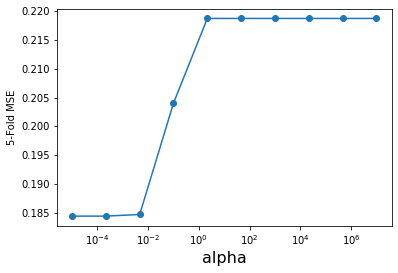

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-5,7,10) # Aquí pongo hasta 10 ya que luego se dispara hacia arriba
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [98]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']*10
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 0.184
MSE Modelo Lasso (test) : 0.193
RMSE Modelo Lasso (train): 0.429
RMSE Modelo Lasso (test) : 0.439
Lesividad 0.049848634189781416
Rango_horario 0.007621766660748308
Dia_semana -0.005183748718818961
Distrito 0.006900216226552125
Tipo_accidente -0.005653057114570296
Tipo_vehiculo 0.10928116644546172
Tipo_persona 0.13521378312358692
Tramo_edad 0.008828682690967182
Latitud 0.013387971788851203
Longitud 0.0005691650728998089
Distancia_ocio_km -0.013449807608017577
Lejania_ocio -0.0026061165291802056
Distancia_radares_km 0.01268679053583435
Lejania_radares 0.00018681209090969813
Year 0.00884188976337378
Mes 0.001960342865989557
Dia -0.002076674355316478
Dia_habil 0.01031887507483816
Condiciones_adversas 0.0
Mal_tiempo 0.0013705075345048195
Mal_carretera -0.0006526174799739532


In [99]:
y_predict_Lasso=lasso.predict(X_test)
print(y_predict_Lasso.mean())
print(df['Sexo'].mean()) 
# Vemos que las medias del precio salen muy diferentes por lo que con este método no estamos prediciendo nada bien.

19.19502517721515
0.3231734583483592


### Arbol de decisión

In [100]:
# Volvemos a cargar para probar ahora con Arboles de decisión
from sklearn import preprocessing
data = df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [101]:
# Lo preparamos para realizar las pruebas
data_test = df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

XtestScaled = scaler.transform(X_test) 

best mean cross-validation score: 0.185
best parameters: {'max_depth': 6}


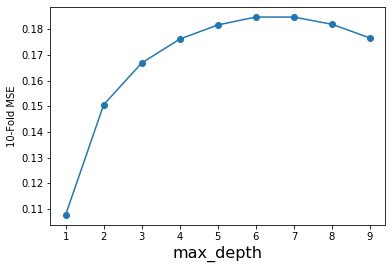

In [102]:
from sklearn.tree import DecisionTreeRegressor

# Vemos con un arbol de decisión
maxDepth = range(1,10)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [103]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

# Con 6 que sería el óptimo nos da un 0.1886 en train y un 0.1844 en test

Train:  0.18869638715515746
Test:  0.18442677107228755


In [104]:
y_predict_decisionTree=grid.predict(X_test)
print(y_predict_decisionTree.mean())
print(df['Sexo'].mean()) 
# Vemos que las medias del precio salen muy parecidas, estaríamos prediciendo bien.

0.32405056901266055
0.3231734583483592


### Random forest

best mean cross-validation score: 0.193
best parameters: {'max_depth': 16}


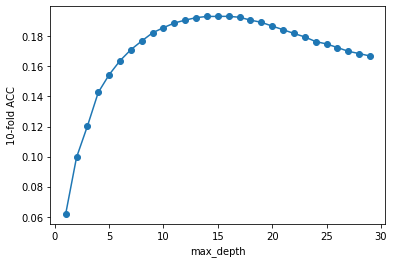

In [105]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

# Con grid search buscamos el óptimo
maxDepth = range(1, 30) 
# Probando veo que está entre estos valores los que mejor resultado dan, lo acoto para que no tarde tanto en cargar.
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train) # Al no ponerle Scoring lo hacemos con accuracy

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

# Cogería 20 porque es muy similar a 29 y así ahorramos complejidad

In [106]:
maxDepthOptimo = 12 #grid.best_params_['max_depth'] # Cogemos 12 para reducir complejidad
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))
# Mejoramos respecto a Lasso

Train:  0.25421291864731743
Test:  0.1915798601449673


In [107]:
y_predict_bagModel=bagModel.predict(X_test)
print(y_predict_bagModel.mean())
print(df['Sexo'].mean()) 
# Vemos que las medias del precio salen muy parecidas, estaríamos prediciendo muy bien.

0.3237254629220018
0.3231734583483592


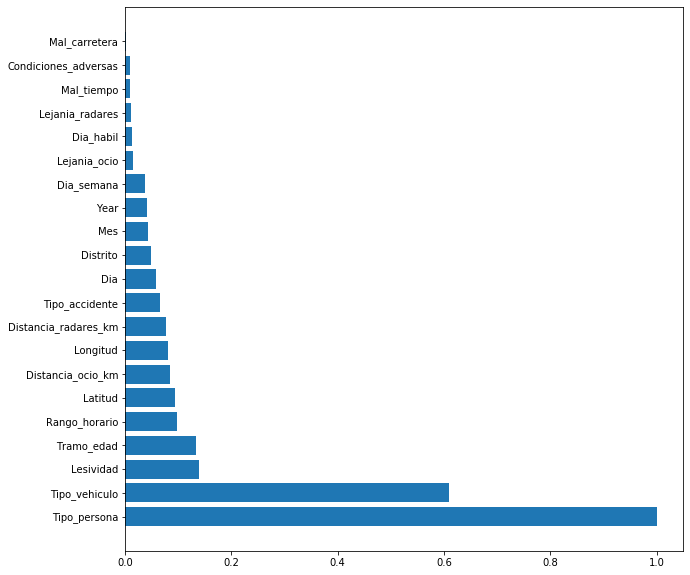

In [108]:
# Vamos a comprobar las variables que son importantes para valorar nuestro modelo
features = df.columns.drop(['Sexo'])

importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

In [109]:
# Vemos que las variables que le da más importancia con Random Forest son algo diferentes a las que nos da Lasso.
# Vamos a dropear las columnas hasta Dia a ver si mejoramos:
# Copio los data frames para dropear columnas sin afectar a mis data frames originales
df_Forest = df.copy()
df_test_Forest = df_test.copy()

In [110]:
df_Forest.drop(['Mal_carretera', 'Condiciones_adversas', 'Mal_tiempo', 'Lejania_radares',
                'Dia_habil', 'Lejania_ocio', 'Dia_semana',  'Year',
                'Mes', 'Distrito'], axis=1, inplace=True)

In [111]:
df_test_Forest.drop(['Mal_carretera', 'Condiciones_adversas', 'Mal_tiempo', 'Lejania_radares',
                'Dia_habil', 'Lejania_ocio', 'Dia_semana',  'Year',
                'Mes', 'Distrito'], axis=1, inplace=True)

In [112]:
# Cargamos el dataframe con nuestras columnas dropeadas
from sklearn import preprocessing
data = df_Forest.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df_Forest.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [113]:
# Lo preparamos para realizar las pruebas
data_test = df_test_Forest.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test_Forest.columns[1:]

XtestScaled = scaler.transform(X_test) 

In [114]:
features = df_Forest.columns.drop(['Sexo'])

best mean cross-validation score: 0.194
best parameters: {'max_depth': 14}


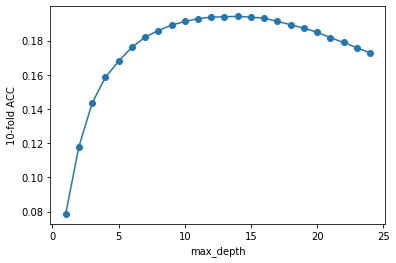

In [115]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

# grid search
maxDepth = range(1, 25) 
# Probando veo que está entre estos valores los que mejor resultado dan, lo acoto para que no tarde tanto en cargar.
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [116]:
maxDepthOptimo = 11 #grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.2326909263724264
Test:  0.19342291537180956


In [117]:
y_predict_bagModel=bagModel.predict(X_test)
print(y_predict_bagModel.mean())
print(df['Sexo'].mean()) 
# Vemos que las medias del precio salen muy parecidas, estaríamos prediciendo muy bien.

0.32339202215607193
0.3231734583483592


In [118]:
# lo vemos graficamente
from sklearn.model_selection import KFold

N,Nfeatures = X_train.shape

rf = RandomForestRegressor(max_depth=11,n_estimators=200,max_features='sqrt')
kf  = KFold(n_splits=10, shuffle = True, random_state=1)
cv_error = []
cv_std = []

for nfeatures in range(Nfeatures,0,-1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        rf.fit(Xt,yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1] 
    
        selected = indices[0:(Nfeatures-nfeatures+1)]
        
        Xs = Xt[:,selected]
        
        rf.fit(Xs,yt)
        error = (1.0-rf.score(Xv[:,selected],yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

# features 1 error 0.8922765208794431 +/- 0.006798447823799566
# features 2 error 0.8405210544089062 +/- 0.007075571160930686
# features 3 error 0.827090927119243 +/- 0.0069696828325918015
# features 4 error 0.8162836931002142 +/- 0.006481097903740466
# features 5 error 0.8092466467206945 +/- 0.0064522534025054585
# features 6 error 0.8062584755295035 +/- 0.006692071812183845
# features 7 error 0.8070454732759167 +/- 0.006818435059380607
# features 8 error 0.8076807696005892 +/- 0.006450372275595195
# features 9 error 0.8065700439536151 +/- 0.006761149125122103
# features 10 error 0.8065593375036533 +/- 0.006593312995034267
# features 11 error 0.8074597466357604 +/- 0.006476781906123965


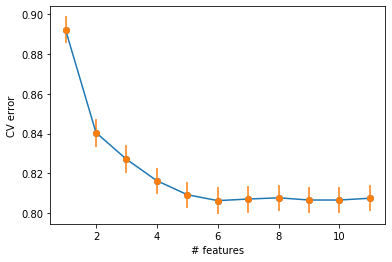

In [119]:
plt.plot(range(1,Nfeatures+1,1),cv_error,'-o')
plt.errorbar(range(1,Nfeatures+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

In [120]:
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo-3).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

Train:  0.19884903963316158
Test:  0.1821294792055036


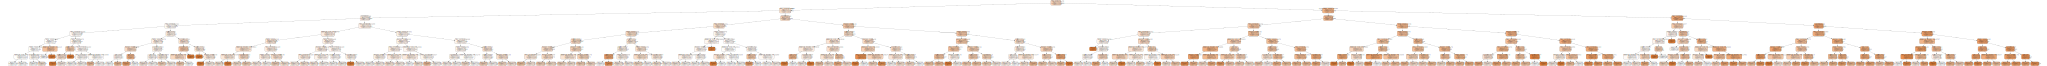

In [121]:
from sklearn.tree import export_graphviz
import graphviz

tree_dot = export_graphviz(treeModel, out_file=None, feature_names=features,  
                         filled=True, rounded=True,  special_characters=True)
graph = graphviz.Source(tree_dot) 
graph
# Se necesita mucha profundidad para llegar a resultados algo óptimos

## Boosted Tree

In [122]:
# Volvemos a cargar nuestro df original
from sklearn import preprocessing
data = df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [123]:
# Lo preparamos para realizar las pruebas
data_test = df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

XtestScaled = scaler.transform(X_test) 

In [124]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor

Niterations = [1500,2000, 2500]
learningRate = [0.1,0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.194
best parameters: {'learning_rate': 0.05, 'n_estimators': 1500}


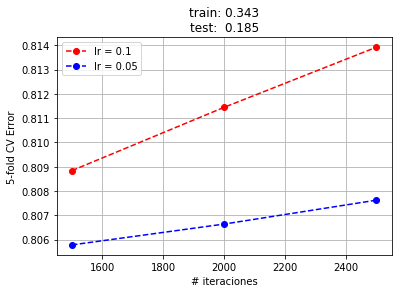

In [125]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=6,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

In [127]:
y_predict_boosted=bt.predict(X_test)
print(y_predict_boosted.mean())
print(df['Sexo'].mean()) 
# Vemos que las medias salen muy parecidas. Con boosted Tree obtenemos una buena predicción.

0.3235378123204273
0.3231734583483592


In [128]:
boostedModel = GradientBoostingRegressor(max_depth=6).fit(X_train,y_train) # Parece que el mejor es con max_depth=6

print("Train: ",boostedModel.score(X_train,y_train))
print("Test: ",boostedModel.score(X_test,y_test))

Train:  0.23016154923649002
Test:  0.19814728162403406


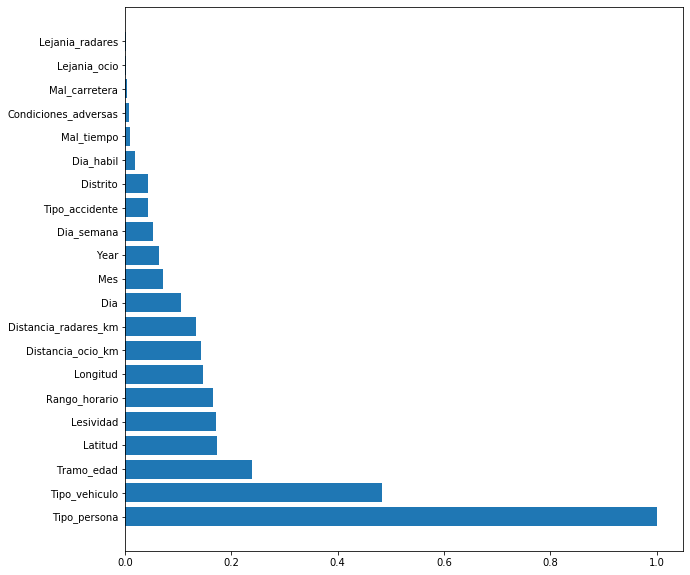

In [129]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

In [131]:
# Copio los data frames para dropear columnas sin afectar a mis data frames originales
df_Boosted = df.copy()
df_test_Boosted = df_test.copy()

In [135]:
# Vamos a quitar columnas según el gráfico de arriba hasta Mes incluido.
df_Boosted.drop(['Lejania_radares', 'Lejania_ocio', 'Mal_carretera', 'Mal_tiempo',
                 'Dia_habil', 'Distrito', 'Tipo_accidente', 'Dia_semana', 'Year', 'Mes'], axis=1, inplace=True)

In [136]:
df_test_Boosted.drop(['Lejania_radares', 'Lejania_ocio', 'Mal_carretera', 'Mal_tiempo',
                 'Dia_habil', 'Distrito', 'Tipo_accidente', 'Dia_semana', 'Year', 'Mes'], axis=1, inplace=True)

In [137]:
# Lo preparamos para realizar las pruebas
from sklearn import preprocessing
data = df_Boosted.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df_Boosted.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [138]:
# Lo preparamos para realizar las pruebas
data_test = df_test_Boosted.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test_Boosted.columns[1:]

XtestScaled = scaler.transform(X_test) 

In [139]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor

Niterations = [1500,2000, 2500]
learningRate = [0.1,0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.192
best parameters: {'learning_rate': 0.05, 'n_estimators': 1500}


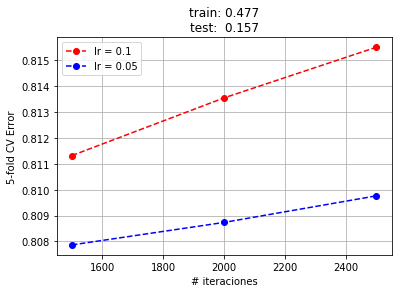

In [140]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=8,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()
# Vemos que empeoran los resultados de test.

In [142]:
y_predict_boosted=bt.predict(X_test)
print(y_predict_boosted.mean())
print(df['Sexo'].mean()) 
# Vemos que las medias salen muy parecidas. Con boosted Tree obtenemos una buena predicción.

0.32420421294822127
0.3231734583483592


In [145]:
boostedModel = GradientBoostingRegressor(max_depth=7).fit(X_train,y_train)

print("Train: ",boostedModel.score(X_train,y_train))
print("Test: ",boostedModel.score(X_test,y_test))

Train:  0.24416503115794186
Test:  0.1951969554034706
